# zeta

In [1]:
import os

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from matplotlib import pyplot as plt

2025-05-30 14:29:55.072938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.listdir('.')

['zeta.ipynb',
 'recruiting_zeta-disease_take-home-challenge.md',
 'recruiting_zeta-disease_training-data_take-home-challenge (1).xlsx',
 'requirements.txt',
 'zeta-disease_predictions.txt',
 'README.md',
 '.gitignore',
 '.venv',
 '.ipynb_checkpoints',
 '.git',
 'recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx',
 '.idea']

In [3]:
df_train = pd.read_excel('recruiting_zeta-disease_training-data_take-home-challenge (1).xlsx')
n_train = len(df_train)
print(n_train)
df_train.head()

800


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


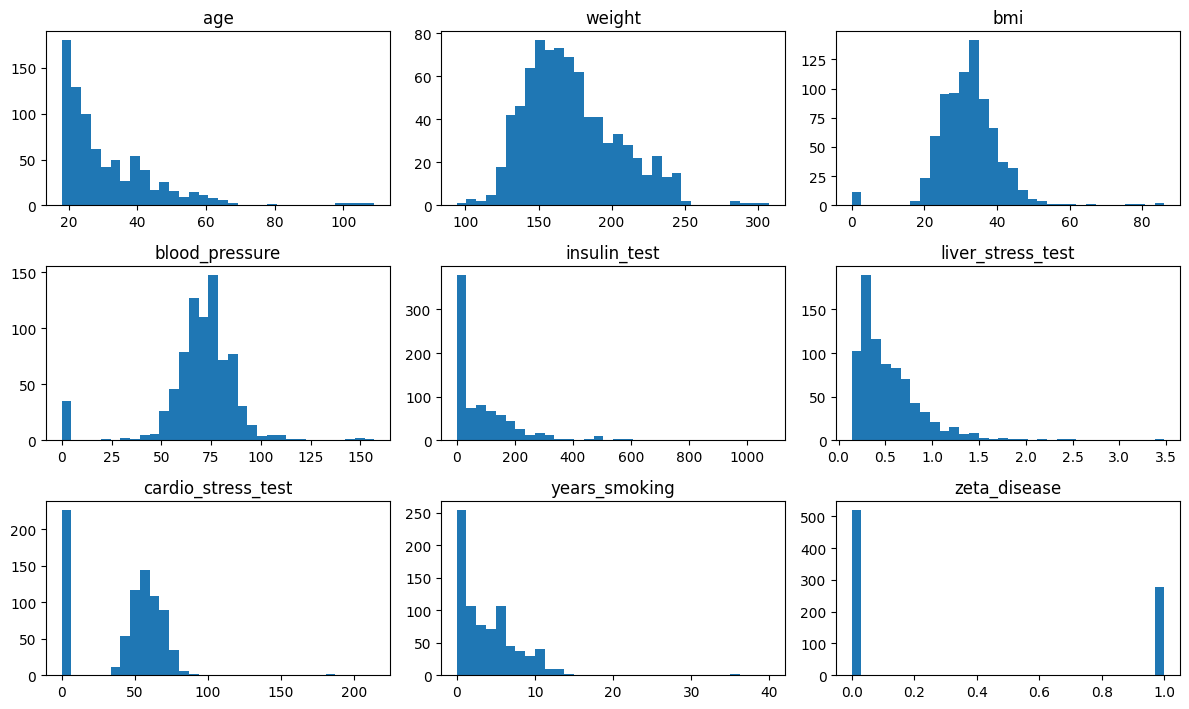

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(12, 7.2))
for i, col in enumerate(df_train.columns):
    ax = axes[i // 3, i % 3]
    ax.set_title(col)
    ax.hist(df_train[col], bins=32)
plt.tight_layout()
plt.show()

It seems like `0` is an invalid (or missing) value for columns `bmi`, `blood_pressure`, `insulin_test`, and `cardio_stress_test`. My first intuition is to add a binary variable to say whether this value was invalid (i.e., missing). It's hard to tell, since some units aren't specified, e.g., insulin may be measured in mIU/L. It's harder to tell because the file actually includes the value `0` (it isn't blank).

`0` seems valid for `years_smoking`, however.

bmi : 789
blood_pressure : 765
insulin_test : 430
cardio_stress_test : 573


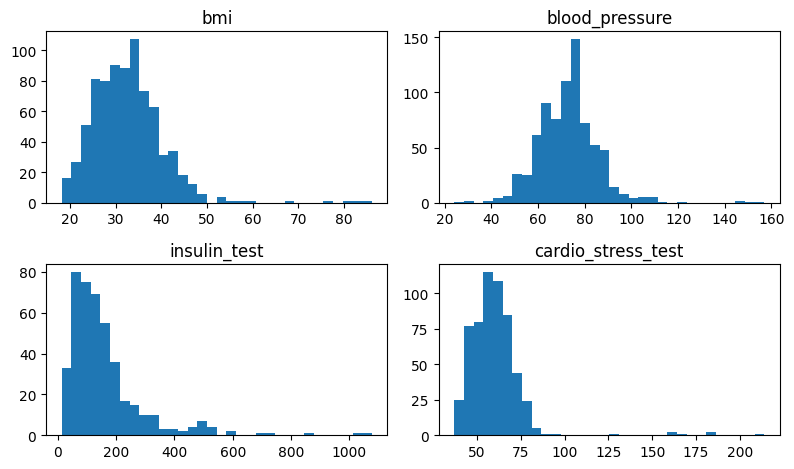

In [5]:
cols_missing = ['bmi', 'blood_pressure', 'insulin_test', 'cardio_stress_test']

fig, axes = plt.subplots(2, 2, figsize=(8, 4.8))
for i, col in enumerate(cols_missing):
    ax = axes[i // 2, i % 2]
    ax.set_title(col)
    s = df_train[col]
    inliers = s[s > 0.0]
    print(col, ':', len(inliers))
    ax.hist(inliers, bins=32)
plt.tight_layout()
plt.show()

I don't have a problem with the other columns. In this toy problem, I can eyeball the distributions and come up with reasonable bounds for normalization.

Otherwise, I would define bounds as a number of standard deviations away from the mean for a normal distribution, or as falling below the 99-ish% threshold for long-tail distributions.

In [6]:
cols_ok = ['age', 'weight', 'liver_stress_test', 'years_smoking']
for col in cols_ok:
    print(col, df_train[col].min(), df_train[col].max())

age 18 109
weight 94 308
liver_stress_test 0.1408 3.4813
years_smoking 0 40


In [7]:
for col in cols_missing:
    s = df_train[col]
    valid = s > 0.0
    print(col, s[valid].min(), s[valid].max())

bmi 18.2 86.1
blood_pressure 24 157
insulin_test 14 1077
cardio_stress_test 37 214


In [8]:
col_to_bounds = {
    'age': (18, 80), 'weight': (100, 250), 'liver_stress_test': (0.14, 1.75), 'years_smoking': (0, 15),
    'bmi': (18, 60), 'blood_pressure': (30, 110), 'insulin_test': (14, 550), 'cardio_stress_test': (37, 90)
}

def transform(df):
    X = list()
    for col in cols_ok + cols_missing:
        min_, max_ = col_to_bounds[col]
        x = df[col].to_numpy()
        X.append(np.maximum(0.0, np.minimum(1.0, (x - min_) / (max_ - min_))))
    for col in cols_missing:
        s = df[col]
        valid = s > 0.0
        X.append(valid.to_numpy().astype(np.float32))
    return np.stack(X, axis=1), df['zeta_disease'].to_numpy()


X_train, y_train = transform(df_train)
print(X_train.shape, y_train.shape)
np.amin(X_train, axis=0), np.amax(X_train, axis=0)

(800, 12) (800,)


(array([0.        , 0.        , 0.00049689, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

## MLP

Other modeling options include `RandomForest`, `KNN`.

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(12,)))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,505 (5.88 KB)

 Trainable params: 1,505 (5.88 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])  # tf.keras.losses.binary_crossentropy

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]
history = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks, validation_split=0.2)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.6265 - loss: 0.6504 - val_binary_accuracy: 0.6375 - val_loss: 0.6414 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6551 - loss: 0.6259 - val_binary_accuracy: 0.6313 - val_loss: 0.6171 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6499 - loss: 0.6129 - val_binary_accuracy: 0.6313 - val_loss: 0.5984 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6688 - loss: 0.5887 - val_binary_accuracy: 0.6750 - val_loss: 0.5709 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6815 - loss: 0.5691 - val_binary_accuracy: 0.7188 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7292 - loss: 0.5355 - val_binary_accuracy: 0.7125 - val_loss: 0.5277 - learning_rate: 0.0010
Epoch 7/1

In [11]:
df_test = pd.read_excel('recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx')
X_test, y_test = transform(df_test)
X_test.shape, y_test.shape

((20, 12), (20,))

In [12]:
y_confidence = model.predict(X_test)
print(y_confidence.shape)
y_pred = (y_confidence > 0.5).astype(np.int32)[:, 0]
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
(20, 1)


array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [13]:
with open('zeta-disease_predictions.txt', 'w') as fd:
    for v in y_pred:
        fd.write(f'{v}\n')

## RandomForest

In [14]:
tree = sklearn.ensemble.RandomForestClassifier(n_estimators=32)
tree.fit(X_train, y_train)

RandomForestClassifier(n_estimators=32)

In [15]:
tree.predict(X_test)

array([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])